# "Magic: The Gathering" Art Classification: Debugging and Refactoring

Hi Rahmy! Use this notebook to write better image classification code. 

Use this section to take note of changes, goals, and outcomes. 

1. Setup Code and Image Preparation have found some new improvements. Image processing has been refactored into its own file image_processing.py. Might want to add comments to image_processing.shuffle_and_split().
2. Viewing a random sample of images has been factored away into fun_stuff.py. I thought of calling the file "utils.py", but I am not sure what utils are supposed to be...


# Setup Code

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import os
import sys

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'DL4CV_HW/MiniProject'
GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))


# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['MTG_images', '__pycache__', 'clf_models', 'mtg_classification.py', 'MtgArtClassification.ipynb', 'salmanr_image_classification_MTG.zip', 'MtgArtV2.ipynb', 'image_processing.py', 'fun_stuff.py']


In [33]:
import os
import time
from mtg_classification import hello_mtg_classification
from image_processing import hello_image_processing


os.environ["TZ"] = "US/Eastern"
time.tzset()
hello_mtg_classification()

mtg_captioning_path = os.path.join(GOOGLE_DRIVE_PATH, "mtg_classification.py")
mtg_captioning_edit_time = time.ctime(os.path.getmtime(mtg_captioning_path))
print("mtg_captioning.py last edited on %s" % mtg_captioning_edit_time, '\n')

hello_image_processing()
image_processing_path = os.path.join(GOOGLE_DRIVE_PATH, "image_processing.py")
image_processing_edit_time = time.ctime(os.path.getmtime(image_processing_path))
print("mtg_captioning.py last edited on %s" % image_processing_edit_time)

Hello from mtg_classification.py!
mtg_captioning.py last edited on Tue May 10 12:48:42 2022 

Hello from image_processing.py!
mtg_captioning.py last edited on Tue May 10 12:55:03 2022


In [34]:
import torch

if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

Please set GPU via Edit -> Notebook Settings.


In [35]:
# Some useful imports!
import math
import os
import time

import matplotlib.pyplot as plt
import torch
from torch import nn

# for plotting
%matplotlib inline
plt.style.use("seaborn")  # Prettier plots
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 24
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# MTG Images Dataset

Transform the MTG_images folder in your Drive to a set of tensors for models to learn. 



In [21]:
# initialize some global constants!

IMAGE_SHAPE = (224, 306) # shrink all images while maintaining a reasonable aspect ratio
IMG_PER_ARTIST = 100
NUM_ARTISTS = 4
VIS_BATCH_SIZE = 4

test_per_artist = 20
val_per_artist = 10
train_per_artist = IMG_PER_ARTIST - test_per_artist - val_per_artist

NUM_TRAIN = NUM_ARTISTS * train_per_artist
NUM_TEST = NUM_ARTISTS * test_per_artist
NUM_VAL = NUM_ARTISTS * val_per_artist 

# Global dtype for tensors
DTYPE = torch.float64

First, convert jpeg in our MTG images dataset to tensors.

In [24]:
from image_processing import PIL_to_tensor_list


mtg_img_tensors = PIL_to_tensor_list(
    imgs_path=os.path.join(GOOGLE_DRIVE_PATH, 'MTG_images'),
    img_shape=IMAGE_SHAPE,
    img_per_artist=IMG_PER_ARTIST,
    dtype=DTYPE,
    device=DEVICE
)

Hamm_imgs = mtg_img_tensors[0]
print('An art print by Hamm in tensor form:\n', Hamm_imgs[50], '\n')
print("All done transforming images!")

An art print by Hamm in tensor form:
 tensor([[[0.2138, 0.1723, 0.1590,  ..., 0.1543, 0.1405, 0.1707],
         [0.3356, 0.2411, 0.2325,  ..., 0.2579, 0.2129, 0.1792],
         [0.4336, 0.2907, 0.2792,  ..., 0.3186, 0.2612, 0.2016],
         ...,
         [0.4606, 0.2994, 0.2866,  ..., 0.2349, 0.1852, 0.1432],
         [0.4351, 0.3002, 0.2709,  ..., 0.2160, 0.1839, 0.1384],
         [0.5588, 0.4328, 0.2814,  ..., 0.2210, 0.2651, 0.1756]],

        [[0.2493, 0.2112, 0.2044,  ..., 0.2092, 0.1975, 0.1785],
         [0.4076, 0.3131, 0.3102,  ..., 0.3189, 0.2739, 0.1914],
         [0.5308, 0.3973, 0.3937,  ..., 0.3916, 0.3357, 0.2197],
         ...,
         [0.5512, 0.4140, 0.4241,  ..., 0.2848, 0.2205, 0.1306],
         [0.5462, 0.4398, 0.4324,  ..., 0.2540, 0.2111, 0.1306],
         [0.6834, 0.5897, 0.4606,  ..., 0.2445, 0.2943, 0.1677]],

        [[0.1500, 0.1140, 0.1062,  ..., 0.1091, 0.0913, 0.1265],
         [0.2650, 0.1705, 0.1693,  ..., 0.1841, 0.1357, 0.1343],
         [0.3489, 0.

Now split the dataset into training and test sets. 

In [29]:
from image_processing import shuffle_and_split

(
  img_train,  
  img_val,  
  img_test,  
  labels_train,
  labels_val,
  labels_test
) = shuffle_and_split(
    dataset=mtg_img_tensors,
    seed=0,
    img_shape=IMAGE_SHAPE,
    num_categories=NUM_ARTISTS,
    num_train=NUM_TRAIN,
    num_val=NUM_VAL,
    num_test=NUM_TEST,
    img_per_artist=IMG_PER_ARTIST,
    train_per_artist=train_per_artist,
    val_per_artist=val_per_artist,
    test_per_artist=test_per_artist,
    dtype=DTYPE,
    device=DEVICE
)

print('Test set:', img_test.shape)
print('Val set:', img_val.shape)
print('Training set:', img_train.shape, '\n')
print('Test labels:', labels_test, '\n')
print('Val labels:', labels_val, '\n')
print('Training labels:', labels_train, '\n')

print('All done creating training and test sets!')

Test set: torch.Size([80, 3, 224, 306])
Val set: torch.Size([40, 3, 224, 306])
Training set: torch.Size([280, 3, 224, 306]) 

Test labels: tensor([3, 0, 2, 3, 1, 3, 1, 0, 0, 3, 2, 2, 1, 3, 2, 2, 0, 2, 1, 3, 1, 1, 0, 0,
        0, 3, 3, 3, 1, 1, 0, 1, 0, 2, 0, 2, 2, 2, 2, 3, 3, 1, 0, 0, 1, 3, 3, 0,
        1, 1, 2, 0, 3, 0, 1, 2, 3, 1, 3, 3, 2, 2, 0, 2, 3, 2, 1, 0, 0, 1, 2, 3,
        0, 1, 3, 2, 1, 2, 0, 1]) 

Val labels: tensor([2, 0, 3, 1, 0, 1, 3, 3, 2, 1, 0, 3, 0, 0, 1, 3, 3, 1, 2, 3, 0, 0, 3, 2,
        0, 2, 0, 2, 1, 2, 3, 1, 1, 2, 2, 1, 1, 2, 0, 3]) 

Training labels: tensor([3, 1, 2, 0, 0, 3, 3, 0, 3, 1, 3, 3, 2, 2, 1, 3, 3, 1, 1, 0, 3, 0, 0, 1,
        2, 1, 0, 1, 0, 1, 3, 2, 1, 3, 1, 2, 0, 2, 2, 0, 2, 0, 1, 1, 2, 3, 3, 3,
        0, 2, 2, 2, 1, 0, 0, 0, 0, 2, 0, 2, 3, 0, 0, 0, 3, 0, 1, 2, 1, 3, 1, 1,
        2, 1, 2, 2, 0, 1, 3, 1, 2, 0, 0, 2, 3, 0, 1, 0, 0, 2, 0, 0, 1, 2, 3, 2,
        2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 2, 2, 0, 2, 3, 3, 2, 1, 1, 3, 3, 3, 0, 2,
        0, 3, 3, 3

# View Random Sample

Run the code block below to view one image from each artist, at random.

Artist order is Hamm, Voss, Nielsen, then McKinnon. 

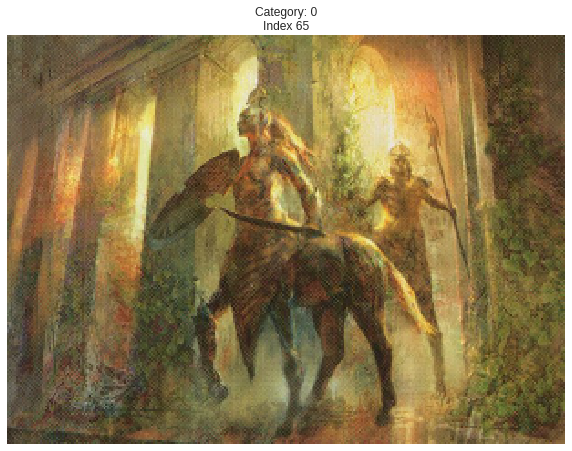

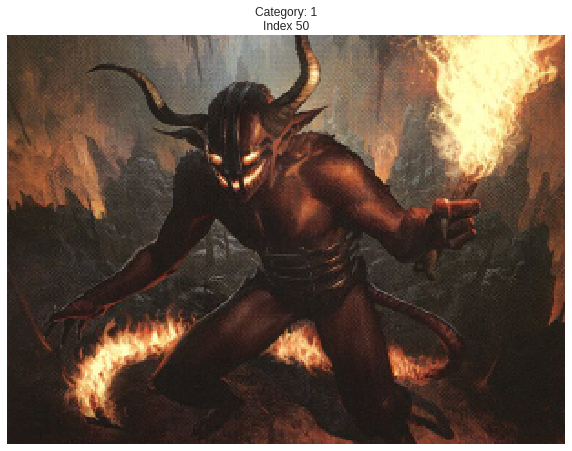

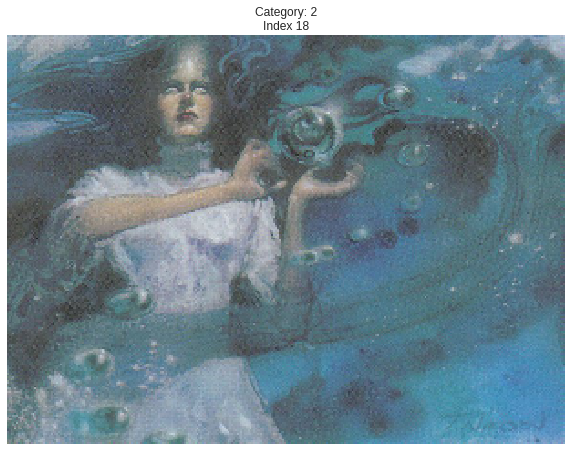

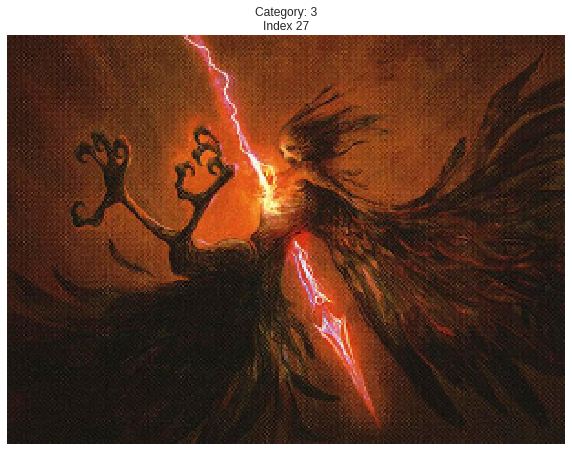

In [48]:
from fun_stuff import view_tensor_sample

view_tensor_sample(dataset=img_train, 
                   labels=labels_train, 
                   num_categories=NUM_ARTISTS)